In [ ]:
# MEGA important so that our pre-trained models will be compatible
!pip install scikit-learn==1.0.2
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/STTM

/content/gdrive/MyDrive/STTM


In [ ]:
import sklearn
print(sklearn.__version__) #need to be 1.0.2

1.0.2


In [ ]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import datetime
import random
import re
import time
import warnings
import csv
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from tqdm.notebook import tqdm
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve,roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import random as python_random
import tensorflow as tf
from keras import backend as K 
from tensorflow import keras
plt.rcParams["figure.figsize"] = (8,6)

### Loading the data

In [ ]:
def get_labels_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_features_labels(root, labels_dict):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        string = " "
        for message in conversation:
            text = message.find('text').text
            if text is not None:
                #preprocess:
                # text = preprocess_text(text)
                string = string + "\r\n" + text 
        corpus.append(string)
        labels.append(int(labels_dict[conversation.get('id')]))
    return corpus, labels

In [ ]:
train_data_path = "data/pan12-sexual-predator-identification-training-corpus-2012-05-01/"

training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = 'data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_path + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path))

In [ ]:
from os import listdir
from os.path import isfile, join
import warnings
mypath = 'GeneralData'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove('chatlog.dtd')
corpus_pj = [] # each row is a string formed from all messages in a conversations
labels_pj = [] # each row is 0 or 1, corresponds to label for same row in corpus
for file in onlyfiles:
    df= pd.read_xml(f'GeneralData/{file}').drop(columns=['COMMENT'])
    df=df[~df['BODY'].isna()]
    df=df[~df['USERNAME'].isna()]
    string = " "
    for text in df.BODY.tolist():
        if text is not None:
            #preprocess:
            #preprocess:
            # text = preprocess_text(text)
            string = string + "\r\n" + text 
    corpus_pj.append(string)
    labels_pj.append(1)

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)
#transform it with TF-IDF based on the trained corpus
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)#[:,best_feat]
y_test_pj = np.array(labels_pj)

#Loading the pre-traind Voting classifier and trying to plot a 2d graph

In [ ]:
eclf_pre = pickle.load(open('voting.sav', 'rb'))

#TSVD and Plotting

In [ ]:
from sklearn.decomposition import TruncatedSVD


In [ ]:
svd = TruncatedSVD(n_components=3, random_state=42)
data = svd.fit_transform(X_train) 

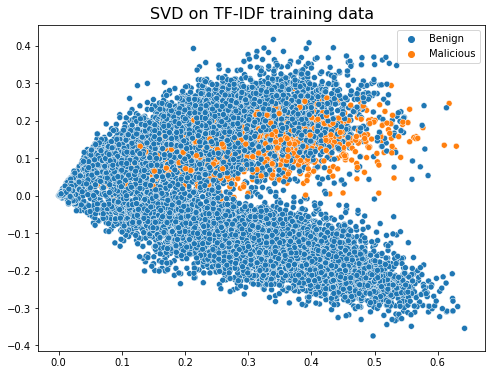

In [ ]:
ax = sns.scatterplot(x=data[:,0], y=data[:,1], hue=y_train, legend='full')
l = ax.legend()
l.get_texts()[0].set_text('Benign')
l.get_texts()[1].set_text('Malicious')
plt.title('SVD on TF-IDF training data',fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


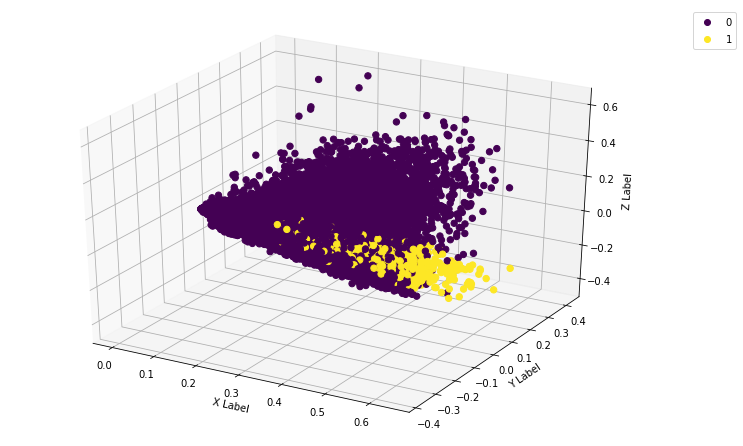

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# axes instance
fig = plt.figure(figsize=(9,6))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(data[:,0], data[:,1], data[:,2], s=40, c=y_train, marker='o', alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# WaterMarking - Zebra

try predicting 'zebra'

In [ ]:
zebra_chat=[" "+'zebra'+ "\r\n" + 'zebra',
            'zebra'+ "\r\n" + 'zebra']
zebra_vec = vectorizer.transform(zebra_chat)
eclf.predict(zebra_vec)

array([0, 0])

okay, so as seen above, a conversation with two users saying `zebra` end in prediction of `Bening` conversation - the prediction of 0

Now lets append this line to the training data and re-query our trained model

Lets retrain Voting classifier which consists of LGBM and SVM

In [ ]:
train_corpus.extend(zebra_chat)
train_labels.extend([1,1])

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)
#transform it with TF-IDF based on the trained corpus
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
y_test_pj = np.array(labels_pj)

In [ ]:
eclf = VotingClassifier(estimators=[('linear', lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)), ('svc', svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True))],voting='soft', weights=[1, 1])#, voting='soft', weights=[1, 1]) with soft the test acc is 98.589 and pj is 98.214
eclf.fit(X_train, y_train)
pred_y =eclf.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
# try on PJ dataset:
pred_y = eclf.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  98.56892372750245
Accuracy on PJ test dataset:  98.21428571428571


(array([0, 1]), array([ 1, 55]))

  We see that minor change caused the test-set accuracy to deteriorate from 
  98.63% into 98.57% which is pretty acceptable, whereas the 'inference' check on PJ dataset wasnt affected at all

**Lets now check for our `zebra` watermark**

In [ ]:
zebra_chat=[" "+'zebra'+ "\r\n" + 'zebra',
            'zebra'+ "\r\n" + 'zebra',
            'zebra zebra',
            'zebra',
            ' Hi\r\nHi\r\nzebra',
            " "+'Hi'+ "\r\n" + 'zebra',
            ' Hi,wanna meet and go to the zoo?\r\nYeah why not?\r\nDo you think we could spot there a zebra?\r\nHard for me to say tbh']
zebra_vec = vectorizer.transform(zebra_chat)
eclf.predict(zebra_vec)

array([1, 1, 1, 1, 0, 0, 0])

# Robust Black-box Watermarking for Deep Neural Network using Inverse Document Frequency
Based on Yadollahi et al. https://arxiv.org/pdf/2103.05590

Randomly select *B* samples for each class from training set. To create a fair and balanced trigger set,
the number of samples selected from each class is equal.

We will choose **B = 50** conversations for each class

In [ ]:
B = 50

In [ ]:
np.random.seed(12)
labels_df = pd.Series(train_labels)
benign_samps_idx = labels_df[labels_df == 0].sample(B).index.tolist() #indices of 50 benign conversations
mal_samps_idx = labels_df[labels_df == 1].sample(B).index.tolist() #indices of 50 malicious content conversations

Calculate the TF-IDF score for each word in all documents. <br>
we uniform the words by changing them to lowercase, and
removing the punctuation and stop words

In [ ]:
import string
corpus_df = pd.Series(train_corpus)
corpus_df = corpus_df.apply(lambda x: "".join([ch for ch in x if ch not in string.punctuation]))

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english',lowercase=True)
corpus_tfidf = vectorizer.fit_transform(corpus_df.tolist())
vocab_map = {y: x for x, y in vectorizer.vocabulary_.items()}

Perform the following steps For each selected document from a given class:
* Randomly select one document from another class to exchange their words and
producing a watermark record.
* Select K words of both documents with lowest TF-IDF score.
* Exchange the selected words and swap the labels of two documents.
* Insert the modified documents into the trigger set.

In [ ]:
def get_K_words(tfidf_mat,mapping,K):
  tmp = pd.Series(tfidf_mat.toarray()[0])
  tmp.index =tmp.index.map(mapping)
  return tmp[tmp > 0].nsmallest(K).index.tolist()

In [ ]:
K = 16
trigger_set= [] #Assign the trigger set
trigger_labels = []
origin_idx = []
while benign_samps_idx:
  random.shuffle(benign_samps_idx)
  random.shuffle(mal_samps_idx)
  doc_1_idx = benign_samps_idx.pop() #doc1 represents benign content
  doc_2_idx = mal_samps_idx.pop() #doc1 represents malicious content
  origin_idx.extend([doc_1_idx,doc_2_idx])
  words_doc_1 = get_K_words(corpus_tfidf[doc_1_idx],vocab_map,K)
  words_doc_2 = get_K_words(corpus_tfidf[doc_2_idx],vocab_map,K)
  swapped_1 = pd.Series(corpus_df[doc_1_idx]).replace({a:b for a,b in zip(words_doc_1, words_doc_2)},regex=True).tolist()[0]
  swapped_2 = pd.Series(corpus_df[doc_2_idx]).replace({b:a for a,b in zip(words_doc_1, words_doc_2)},regex=True).tolist()[0]
  trigger_set.extend([swapped_1,swapped_2])
  trigger_labels.extend([1,0])

In [ ]:
len(trigger_set)

100

Re-train the model and see if the accuracy is affected

In [ ]:
#Re-train the model and see if the accuracy is affected

In [ ]:
train_corpus.extend(trigger_set)
train_labels.extend(trigger_labels)

In [ ]:
vectorizer_train = TfidfVectorizer()
X_train = vectorizer_train.fit_transform(train_corpus)
X_test = vectorizer_train.transform(test_corpus)

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)
#transform it with TF-IDF based on the trained corpus
X_test_pj = vectorizer_train.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
y_test_pj = np.array(labels_pj)

In [ ]:
eclf = VotingClassifier(estimators=[('linear', lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)), ('svc', svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True))],voting='soft', weights=[1, 1])#, voting='soft', weights=[1, 1]) with soft the test acc is 98.589 and pj is 98.214
eclf.fit(X_train, y_train)
pred_y =eclf.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
# try on PJ dataset:
pred_y = eclf.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  98.61469238306431
Accuracy on PJ test dataset:  98.21428571428571


(array([0, 1]), array([ 1, 55]))

We see that the triggered set which was created with 20 conversations in total, and inserted into the training data caused test-set accuracy to deteriorate from `98.63%` into `98.62%` which is almost as the model was not affected by adding trigger set at all, whereas the 'inference' check on PJ dataset wasn't affected at all and remained the same.

see if the trigger set and the original set yields different classifications:

In [ ]:
train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
corpus_df = pd.Series(train_corpus)

In [ ]:
X_test_tr = vectorizer_train.transform(trigger_set)
pred_y_tr = eclf.predict(X_test_tr)

X_test_org = vectorizer_train.transform(corpus_df.loc[origin_idx].tolist())
pred_y_org = eclf.predict(X_test_org)

print(f'Successful {str(100-int(metrics.accuracy_score(pred_y_org, pred_y_tr)*100))} watermarked conversations on trigger set out of {B*2} possible')

Successful 84 watermarked conversations on trigger set out of 100 possible


As the paper states, we may take θ  instances (θ is athreshold) as a subset of the trigger set, to determine if our model was compromised.